<a href="https://colab.research.google.com/github/Jaksta1/Uczenie_Maszynowe_2025/blob/main/Jakub_Kownacki_praca_domowa_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

------------------------------------
# Część 1. Pytania teoretyczne
------------------------------------

## 1. Co to jest transponowana konwolucja?
Transponowana konwolucja (czasami nazywana „dekonwolucją”, choć to technicznie inna operacja) to metoda wykorzystywana w sieciach neuronowych do zwiększania rozdzielczości danych przestrzennych, np. obrazów.

Działa w sposób odwrotny do klasycznej konwolucji:

* Zwykła konwolucja przekształca obraz w mniejszą mapę cech (ang. feature map) – dokonuje kompresji.

* Transponowana konwolucja rozciąga zakodowaną reprezentację z powrotem do większej siatki – dokonuje rekonstrukcji.

Technicznie polega to na „odwróceniu” procesu przesuwania jądra konwolucyjnego po obrazie. Zamiast przesuwać filtr po dużym obrazie i uzyskiwać pojedyncze wartości, filtr stosowany jest na pojedynczych wartościach zakodowanej reprezentacji, rozlewając swój wpływ po większej przestrzeni.

## 2. Czym różni się transponowana konwolucja od zwykłej konwolucji?
W poniższej tabeli znajduje się porównanie konwolucji transponowanej oraz zwykłej.

| **Cecha**               | **Zwykła konwolucja (`Conv2d`)**                                                                 | **Transponowana konwolucja (`ConvTranspose2d`)**                                                 |
|-------------------------|--------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------|
| **Główny cel**          | Ekstrakcja lokalnych cech i **redukcja rozdzielczości** obrazu (np. 28×28 → 14×14).              | **Rekonstrukcja** lub odtworzenie obrazu z mniejszej reprezentacji (np. 7×7 → 14×14).            |
| **Kierunek działania**  | „W dół” – *downsampling*: zmniejsza przestrzenny wymiar danych wejściowych.                     | „W górę” – *upsampling*: zwiększa przestrzenny wymiar danych wyjściowych.                         |
| **Zasada działania**    | Przesuwanie filtra po wejściu i sumowanie iloczynów.                                             | Rozprowadzanie wartości wejściowych na większy obszar wyjścia za pomocą jądra (filtra).           |
| **Efekt na rozmiar**    | Wyjście jest **mniejsze** niż wejście (chyba że zastosujemy padding).                            | Wyjście jest **większe** niż wejście (zależnie od stride, paddingu i wielkości filtra).          |
| **Typowe miejsce użycia** | Warstwy kodujące (encodery) w sieciach CNN, klasyfikacja, detekcja cech.                      | Warstwy dekodujące (decodery) w autoenkoderach, U-Net, GAN-ach – tam, gdzie potrzebna rekonstrukcja. |
| **Struktura danych**    | Często używana do tworzenia zwartej reprezentacji wejściowego obrazu.                          | Służy do odtworzenia struktury danych z zakodowanego (ściśniętego) przedstawienia.                |
| **Intuicja**            | Redukuje ilość informacji, skupiając się na istotnych cechach.                                  | Odtwarza obraz poprzez „rozlewanie” zakodowanych informacji po większej przestrzeni.             |


## 3. Jak transponowana konwolucja zwiększa rozmiar map cech (upsampling)?
Przedstawmy szczegółowy opis procesu transponowanej konwolucji (upsamplingu) w pięciu etapach. Dzięki tym krokom czytelnik będzie w stanie zaimplementować operację samodzielnie.

1. **Parametry wejściowe**  
   - Wejściowa mapa cech: $H_{in} × W_{in}$  
   - Kernel: $K × K$  
   - Stride: $S$  
   - Padding: $P$  

2. **Obliczenie rozmiaru wyjściowego**
   - $H_{out} = (H_{in} − 1) × S − 2P + K$
   - $W_{out} = (W_{in} − 1) × S − 2P + K$

Przykład: $H_{in}=W_{in}=2$, $K=3$, $S=2$, $P=1$ →\
$H_{out} = (2−1)×2 − 2·1 + 3 = 3$\
$W_{out} = (2−1)×2 − 2·1 + 3 = 3$\
Wyjście będzie miało wymiary $3×3$.

3. **Rozmieszczenie wartości i wstawianie zer**  
a. Obliczmy wymiary tymczasowej macierzy:  
   $H_{temp} = H_{in} + (H_{in} − 1)×(S − 1)$\
   $W_{temp} = W_{in} + (W_{in} − 1)×(S − 1)$\
b. Utwórzmy macierz $H_{temp} × W_{temp}$ i wypełnijmy ją zerami.  
c. Kopiujemy oryginalne wartości tak, aby element $(i,j)$ oryginału trafił na
 pozycję $(i×S, j×S)$ w tej macierzy.  

Przykładowo dla macierzy:

\begin{bmatrix}
a & b \\
c & d
\end{bmatrix}

oraz $ S = 2 $ otrzymujemy:

\begin{bmatrix}
a & 0 & b \\
0 & 0 & 0 \\
c & 0 & d
\end{bmatrix}

4. **Właściwa konwolucja**  
a. Używamy kernela $K×K$.\
b. Przesuwamy go po „temp” macierzy z krokiem 1.\
c. Dla transponowanej konwolucji macierzy "temp" wymiaru $H_{temp} × W_{temp}$ i jądra wymiaru $K\times K$, wynikowa macierz "conv" ma wymiary $(H_{temp}+K-1)\times(W_{temp}+K-1)$ i jej ogólny element wyraża się wzorem\
$conv[i,j]=\sum_{p=0}^{H_{temp}-1}\;\sum_{q=0}^{W_{temp}-1}temp[p,q]\times k[i - p,j - q]$ przy czym przyjmujemy, że
$
k[u,v] = 0
\quad\text{gdy}\quad
u < 0 \;\lor\; u \ge K
\quad\text{lub}\quad
v < 0 \;\lor\; v \ge K.
$\
Indeksy $i$ i $j$ przebiegają kolejno od $0$ do $H_{temp}+K-2$ oraz od $0$ do $W_{temp}+K-2$.

5. **Dodanie paddingu**  
a. Aby uwzględnić padding P, obcinamy P rzędów i kolumn macierzy "conv" z każdej strony:
Nowy rozmiar:\
$H_{out} = H_{conv} - 2P$\
$W_{out} = W_{conv} - 2P$

**Podsumowanie przepływu**

a. Wejście: $H_{in}×W_{in}$

b. Wstawianie zer → $H_{temp}×W_{temp}$

c. Konwolucja $K×K$ → Wyjście $H_{conv}×W_{conv}$

d. Dodanie paddingu → $H_{out}×W_{out}$

# 4. Co to są stride, padding i rozmiar jądra (kernel size) oraz jak wpływają na wynik w konwolucji transponowanej?

1. **Rozmiar jądra (kernel size)**  
   - Rozmiar jądra $K×K$ to wymiary filtra, który w transponowanej konwolucji „rozrzuca” każdą wartość wejściową na blok $K×K$.    
   - Większe jądro––większe miejsce, z którego pobieramy i rozrzucamy informacje:  
     - **Małe jądro** (np. $3×3$) daje bardziej „zwięzłe”, skoncentrowane rozciągnięcie sygnału.  
     - **Duże jądro** (np. $7×7$) powoduje silniejsze rozmycie/rozprzestrzenienie się informacji, większą „fuzję” sąsiednich pikseli.
  - Rozmiar wyjścia: każdy wzrost `k` o 1 powiększa wymiar wyjścia o 1 w obu osiach zgodnie z formułami $H_{out} = (H_{in} - 1)·S - 2P + K$ oraz $W_{out} = (W_{in} - 1)·S - 2P + K$   

2. **Krok (stride)**

- **Definicja:** w transposed convolution „stride” określa, o ile „rozsadzamy” (upsamplujemy) rozmiar wejścia przed zastosowaniem jądra, czyli w praktyce wstawiamy między piksele zera.
  
- **Mechanizm działania:**
  1. **Wstawianie zer:** przy stride = S między każde dwa sąsiednie wiersze i kolumny oryginalnej mapy cech wstawiamy po `s−1` wierszy/kolumn zer.
  2. **Konwolucja:** następnie przesuwamy filtr o 1 w obu osiach.

- **Przykłady:**
  - `stride = 1`  
    - Brak zer; wyjście ma rozmiar zbliżony do wejścia (z uwzględnieniem paddingu i jądra).  
  - `stride = 2`  
    - Wstawiamy 1 wiersz/kolumnę zer między oryginalne piksele → rozmiar siatki przed konwolucją wzrasta ≈ dwukrotnie.  
    - Każdy piksel wejściowy trafia więc w wyniku na co drugą pozycję.
  - `stride = 3`  
    - Wstawiamy 2 wiersze/kolumny zer → rozmiar wyjścia ≈ trzykrotnie większy.

- **Wpływ na rozmiar wyjścia:**  
  - Zwiększenie `stride` liniowo skaluje wyjście o czynnik S (minus korekta z paddingu i jądra) zgodnie z wzorem podanym w punkcie **1.Rozmiar jądra**.

3. **Padding**  
- **Definicja:** w transposed convolution „padding” to liczba pikseli obcinanych z każdej krawędzi wynikowej mapy po rozrzuceniu i nałożeniu jądra.

- **Mechanizm działania:**
  1. Po wstawieniu zer (zgodnie ze `stride`) i zastosowaniu filtra otrzymujemy tymczasową mapę o pełnym rozciągnięciu.
  2. Następnie z każdej krawędzi tej mapy usuwamy (`crop`) po `padding` pikseli.

- **Przykłady:**
  - `padding = 0`  
    - Pełne rozciągnięcie – nic nie obcinamy.
  - `padding = 1`  
    - Obcinamy 1 piksel z każdej krawędzi → redukcja wymiaru o 2 piksele (po jednym z każdej strony).
  - `padding = 2`  
    - Obcinamy 2 piksele z każdej krawędzi → redukcja wymiaru o 4 piksele.

- **Wpływ na wynik:**
  - Pozwala precyzyjnie dostroić rozmiar wyjścia, usuwając nadmiarowe brzegi powstałe przy upsamplingu.
  - Może zapobiegać artefaktom na krawędziach (nierównomierne nakładanie filtrów).
  - Wpływ na rozmiar wyjścia opisują wzory podane w punkcie **1. Rozmiar jądra**

------------------------------
# Część 2. Schemat odręczny
------------------------------

##Dane wejściowe:

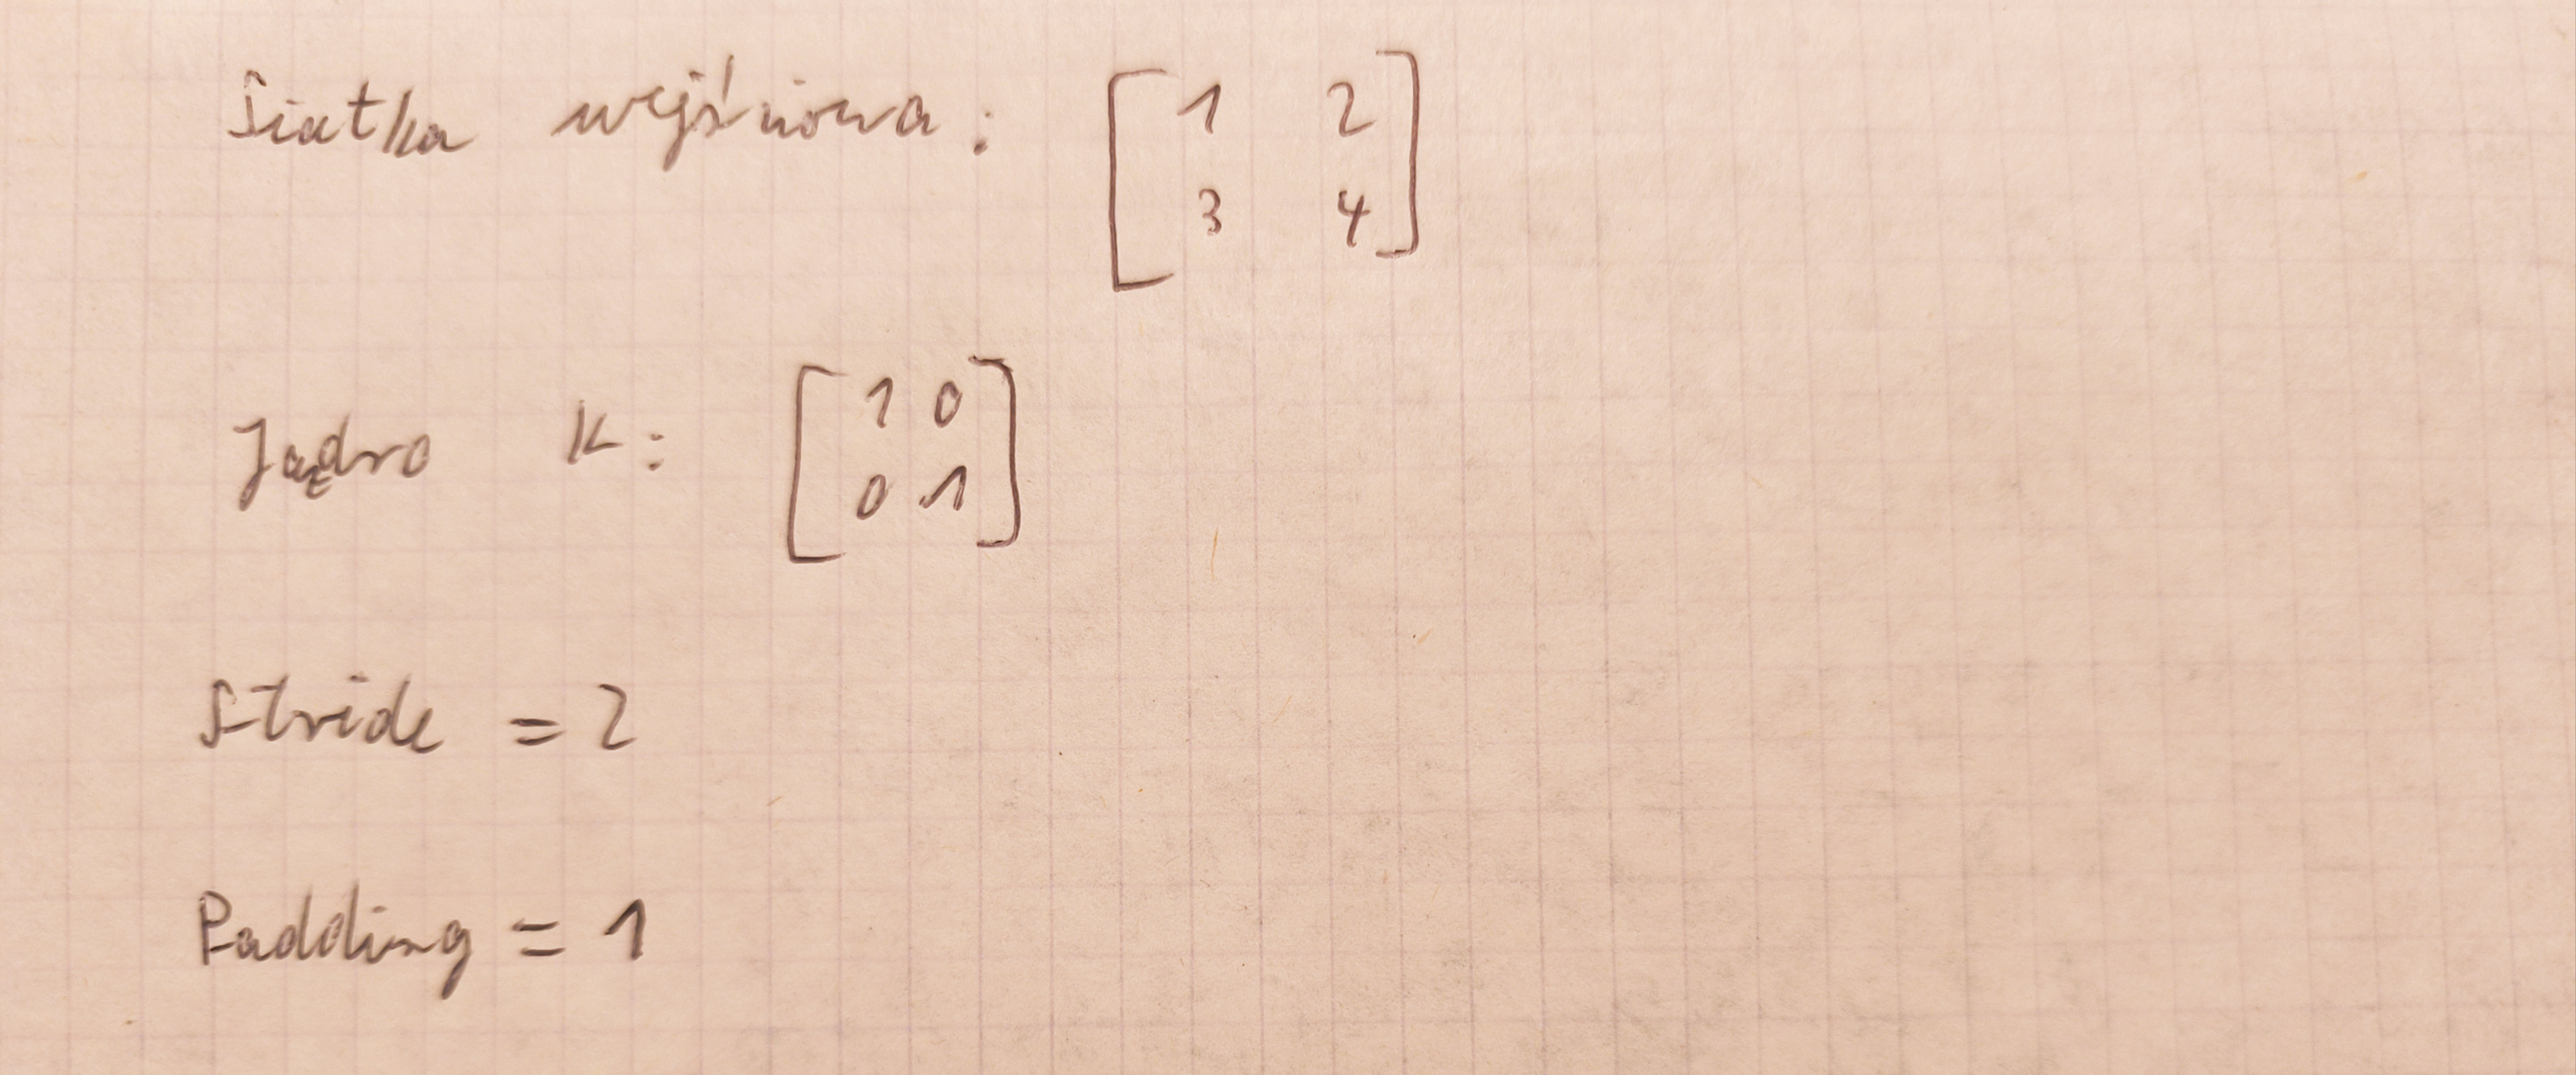

## Krok 1: Stride

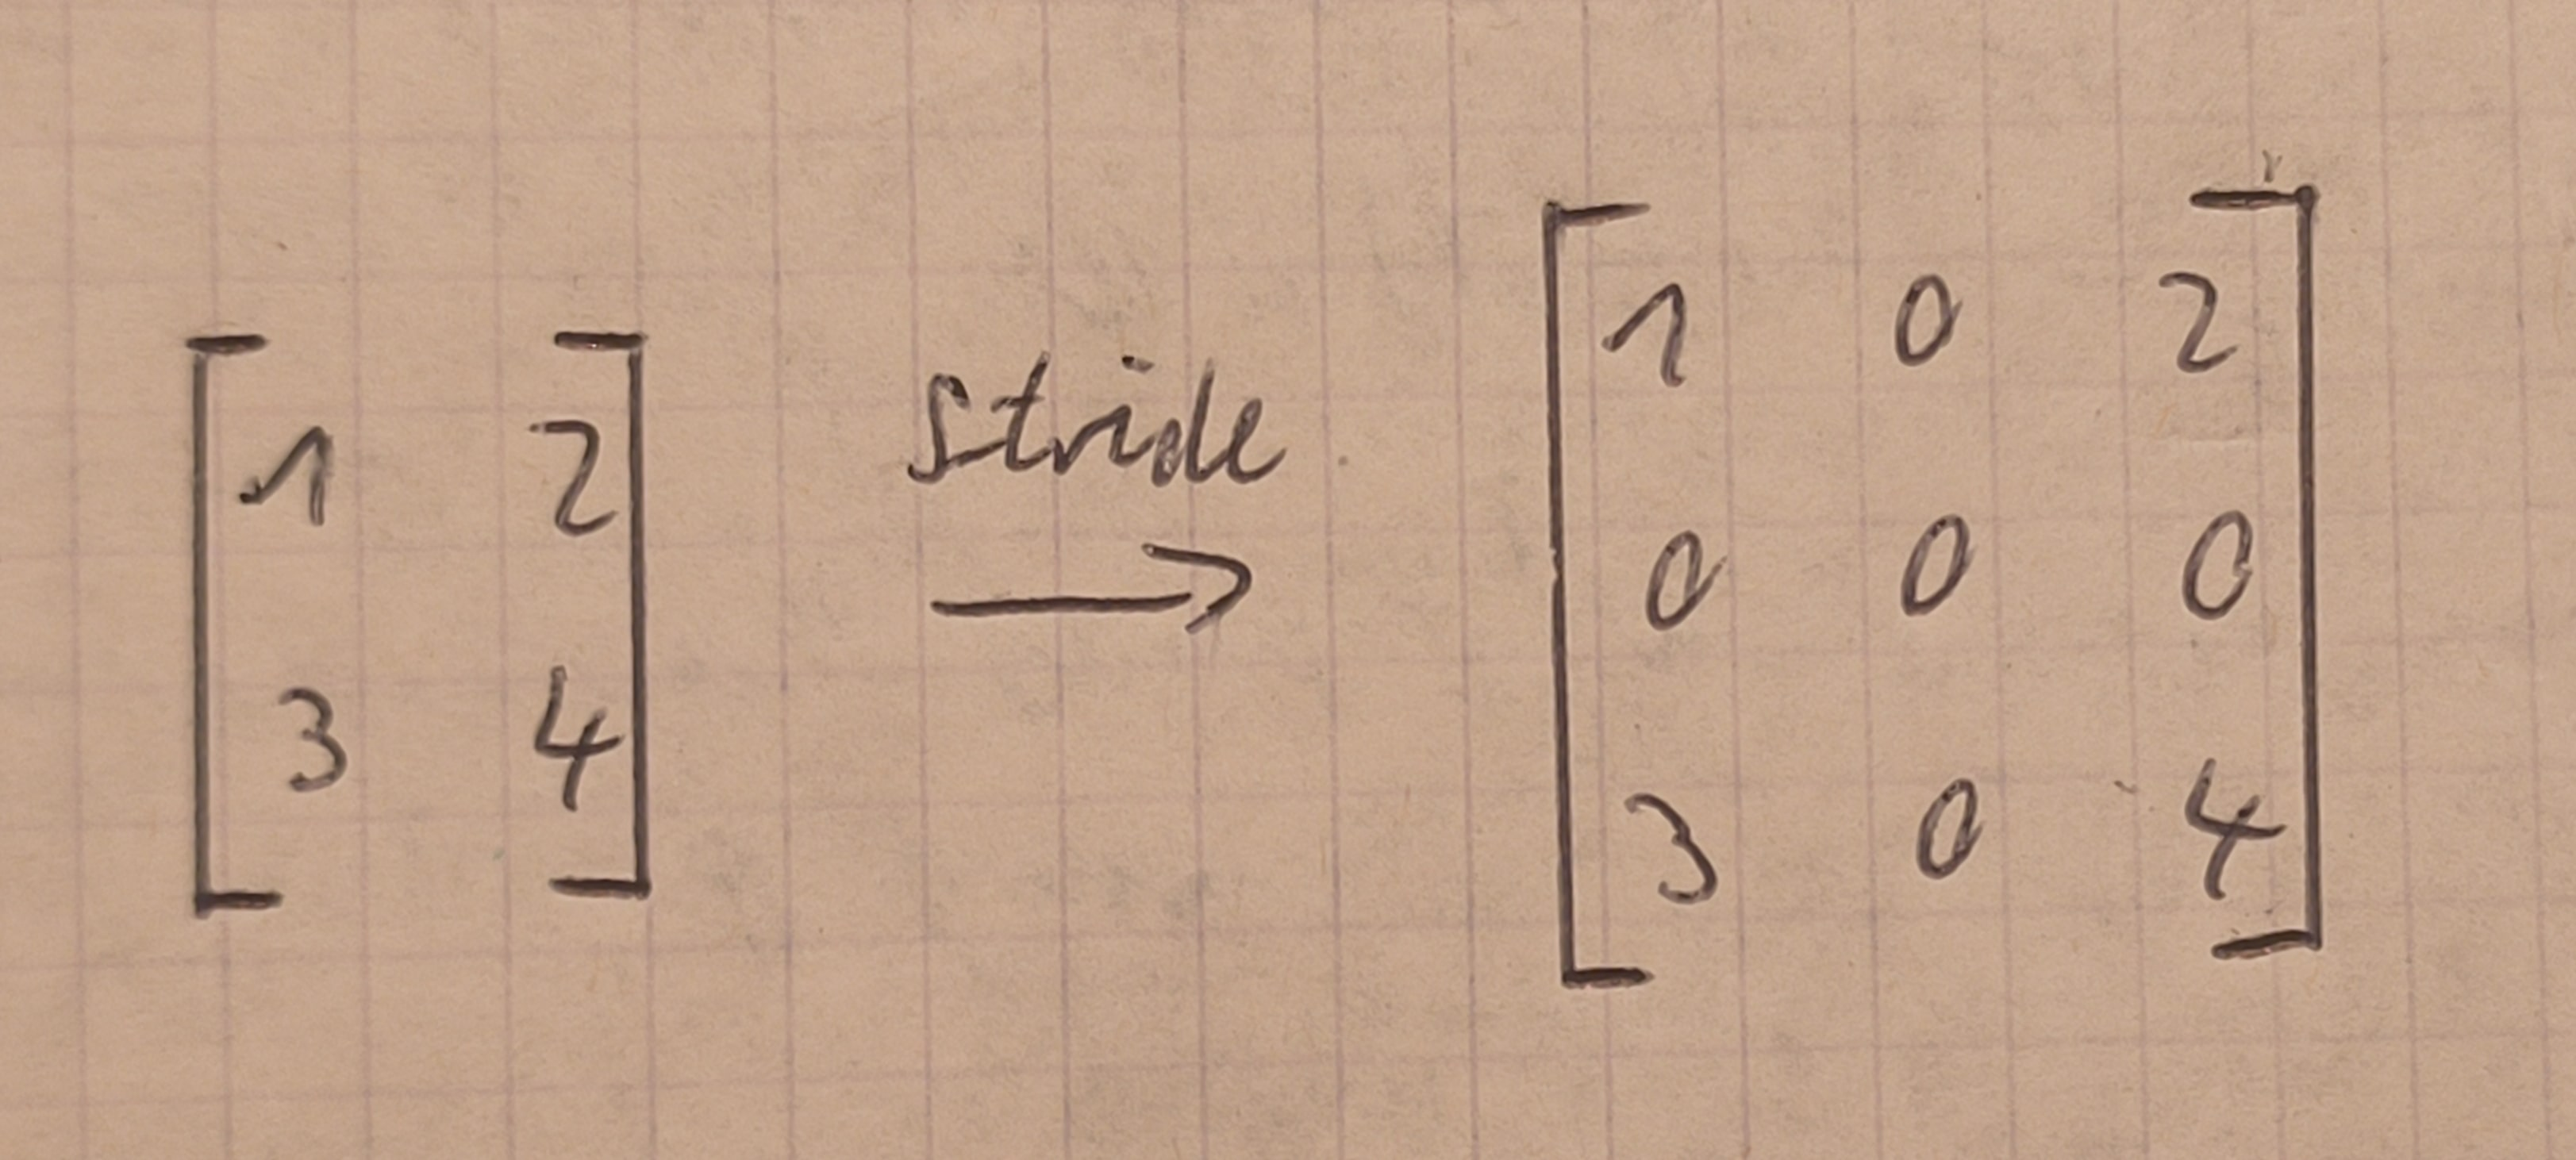

## Krok 2: Konwolucja jądrem K

IMG_20250525_220140-min.jpg

## Krok 3: Padding i wynik

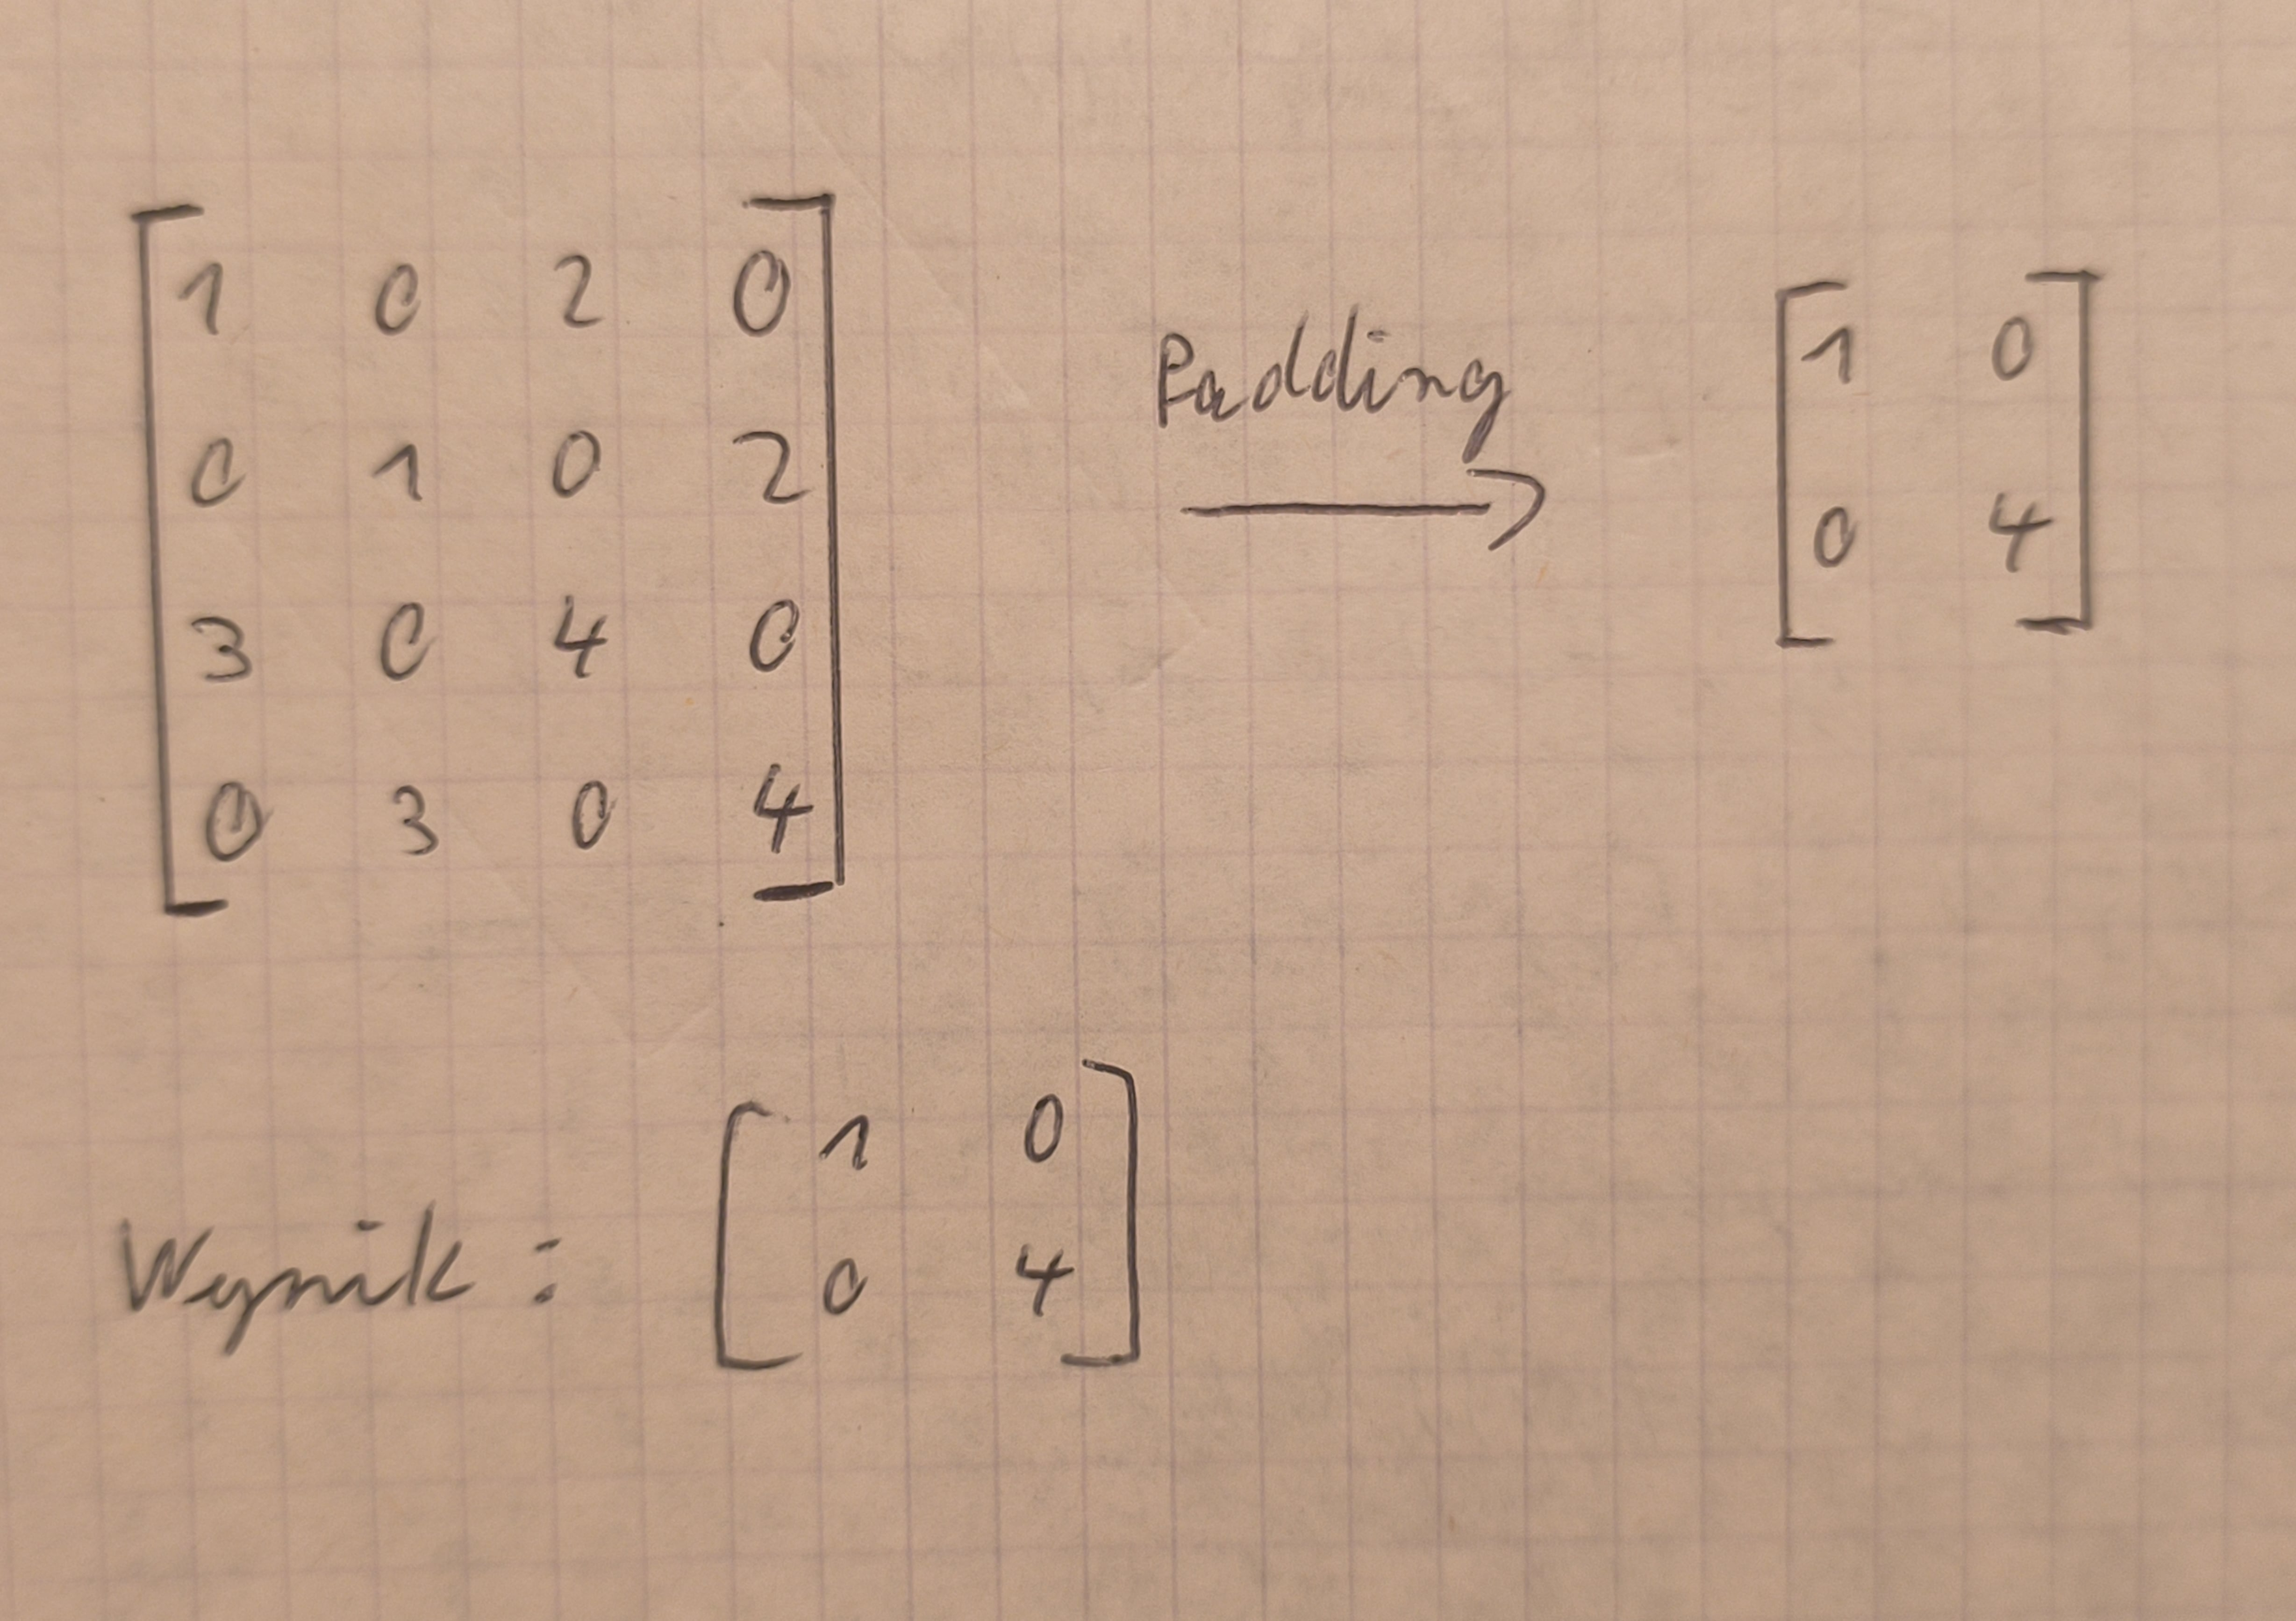